In [35]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.model_selection import KFold

The aim of this short project is to create an image classification model. Each row in my dataset is an image. The dataset has 63 columns and the values represent different degrees of shading for each pixel in the image. For predictions, I will compare using a clustering method to a neural network.

## Data Loading and Exploration

In [36]:
## creating training and target dataframes

train = load_digits()
target = pd.DataFrame(train.target)
target[0:3]

,0
0,0
1,1
2,2


In [37]:
train_data = pd.DataFrame(train.data)
train_data[0:3]

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0


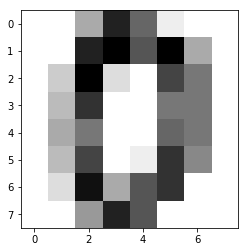

In [38]:
first_image = train_data.iloc[0]
np_image = first_image.values.reshape(8,8)
plt.imshow(np_image, cmap='gray_r')

In [39]:
## converting sample rows to images and storing in a dictionary

rows = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
dictionary = {}

for row in rows:
    image = train_data.iloc[row]
    dictionary[row] = image.values.reshape(8,8)

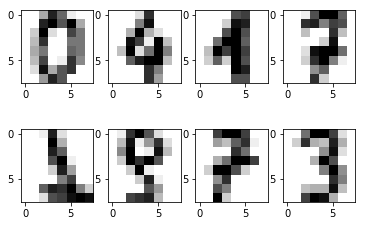

In [40]:
## creating a visualization of sample images

fig = plt.figure()
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(dictionary[0], cmap='gray_r')
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(dictionary[100], cmap='gray_r')
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(dictionary[200], cmap='gray_r')
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(dictionary[300], cmap='gray_r')
ax5 = fig.add_subplot(2,4,5)
ax5.imshow(dictionary[1000], cmap='gray_r')
ax6 = fig.add_subplot(2,4,6)
ax6.imshow(dictionary[1100], cmap='gray_r')
ax7 = fig.add_subplot(2,4,7)
ax7.imshow(dictionary[1200], cmap='gray_r')
ax8 = fig.add_subplot(2,4,8)
ax8.imshow(dictionary[1300], cmap='gray_r')

In [41]:
## verify above images with target column

print(target.iloc[rows])

      0
0     0
100   4
200   1
300   7
1000  1
1100  9
1200  7
1300  3


These eight images are handwritten numbers. By comparing what we see in the images with the target column, we can see how our classification model will need to understand various handwriting styles and still provide an accurate prediction.

In [42]:
## creating a combined dataframe then splitting for training and testing

train_data['numbers'] = target
shuffled = train_data.sample(frac=1, random_state=1)
half = int(len(shuffled) / 2)
train = shuffled.loc[:half].copy()
test = shuffled.loc[half:].copy()

In [43]:
## creating functions for a k-nearest neighbors classifier

from sklearn.metrics import accuracy_score

features = shuffled.drop(['numbers'], axis=1).columns

def train_knn(data, k):
    knn = KNeighborsClassifier(k)
    knn.fit(data[features], data['numbers'])
    return knn

def test_knn(test_data, model):
    test_data['predictions'] = model.predict(test_data[features])
    return test_data

knn = train_knn(train, 3)
tested = test_knn(test, knn)
accuracy_score(tested['numbers'], tested['predictions'])

0.8059023836549376

In [44]:
## using k-fold cross validation with 4 folds

def cross_validate(data, k):
    kf = KFold(n_splits=4, shuffle=True, random_state=2)
    accuracies = []
    model = KNeighborsClassifier(k)
    features = data.drop(['numbers'], axis=1).columns
    for train_index, test_index in kf.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model.fit(train[features], train['numbers'])
        predictions = model.predict(test[features])
        accuracy = accuracy_score(test['numbers'], predictions)
        accuracies.append(accuracy)
    avg_accuracy = np.mean(accuracies)
    print(k, "neighbors and 4 folds avg_accuracy:", avg_accuracy)
    return avg_accuracy

for i in range(2, 10):
    cross_validate(train_data, k=i)

2 neighbors and 4 folds avg_accuracy: 0.9821912892848305
3 neighbors and 4 folds avg_accuracy: 0.9872011878247959
4 neighbors and 4 folds avg_accuracy: 0.9833073496659243
5 neighbors and 4 folds avg_accuracy: 0.9849777282850779
6 neighbors and 4 folds avg_accuracy: 0.9827517941103686
7 neighbors and 4 folds avg_accuracy: 0.9844221727295223
8 neighbors and 4 folds avg_accuracy: 0.9805270972531551
9 neighbors and 4 folds avg_accuracy: 0.9827567433803515


Accuracy using k-fold cross validation drastically improved. This could be because the KFold function trains itself on much more of the dataset than simply splitting it in half. The number of neighbors used seems to have a relatively minor affect on accuracy, but the top result is 3 neighbors.

## Training a Neural Network

Next I will train a neural network on the data including varying the numbers of neurons in the single hidden layer and using 4-fold cross validation.

In [45]:
## neural network model with one hidden layer

from sklearn.neural_network import MLPClassifier

def nn_classifier(data):
    neurons = [8, 16, 32, 64, 128, 256]
    nn_accuracies = []
    kf = KFold(n_splits=4, shuffle=True, random_state=2)
    fold_accuracies = []
    
    for n in neurons:
        mlp = MLPClassifier(hidden_layer_sizes=(n,), activation='relu', max_iter=1000)

        # include 4 fold validation
        for train_index, test_index in kf.split(data):
            train, test = data.iloc[train_index], data.iloc[test_index]
            mlp.fit(train[features], train['numbers'])
            nn_predictions = mlp.predict(test[features])
            accuracy = accuracy_score(test['numbers'], nn_predictions)
            fold_accuracies.append(accuracy)
            
        avg_accuracy = np.mean(fold_accuracies)
        nn_accuracies.append(avg_accuracy)
        print(n, "neurons", avg_accuracy)
        
    return nn_accuracies

nn_classifier(shuffled)

C:\Users\brode\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\brode\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\brode\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


8 neurons 0.9360133630289533
16 neurons 0.9476961148230636
32 neurons 0.9543706178338695
64 neurons 0.9591001608512744
128 neurons 0.9624939371442712
256 neurons 0.9650344386702961


[0.9360133630289533,
 0.9476961148230636,
 0.9543706178338695,
 0.9591001608512744,
 0.9624939371442712,
 0.9650344386702961]

With one hidden layer in my neural network, as we increased the number of neurons, the accuracy improved accordingly. 256 neurons brings us an accuracy of 96.7%, compared to 98.7% for the best knn classifier. Next I will try using 256 neurons in two hidden layers.

In [46]:
## increasing the neural network to 2 hidden layers and 256 neurons in each

def nn_classifier(data, n, k):
    nn_accuracies = []
    kf = KFold(n_splits=k, shuffle=True, random_state=2)
    fold_accuracies = []
    mlp = MLPClassifier(hidden_layer_sizes=(n,n), activation='relu', max_iter=1000)

    # include 4 fold validation
    for train_index, test_index in kf.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        mlp.fit(train[features], train['numbers'])
        nn_predictions = mlp.predict(test[features])
        accuracy = accuracy_score(test['numbers'], nn_predictions)
        fold_accuracies.append(accuracy)
            
    avg_accuracy = np.mean(fold_accuracies)
    nn_accuracies.append(avg_accuracy)
    print("256 neurons and 2 layers", avg_accuracy)    
    return nn_accuracies

nn_classifier(shuffled, 256, 4)

256 neurons and 2 layers 0.9782949764909675


[0.9782949764909675]

In [47]:
## modifying neural networks to 3 hidden layers, varying neurons in each, and 6 folds for validation
## 3 model with 3 hidden layers of 10, 64, and 128 neurons

def nn_classifier(data, k):
    neurons = [10, 64, 128]
    nn_accuracies = []
    kf = KFold(n_splits=k, shuffle=True, random_state=2)
    fold_accuracies = []
    
    for n in neurons:
        mlp = MLPClassifier(hidden_layer_sizes=(n,n,n), activation='relu', max_iter=1000)

        # include 6 fold validation
        for train_index, test_index in kf.split(data):
            train, test = data.iloc[train_index], data.iloc[test_index]
            mlp.fit(train[features], train['numbers'])
            nn_predictions = mlp.predict(test[features])
            accuracy = accuracy_score(test['numbers'], nn_predictions)
            fold_accuracies.append(accuracy)
            
        avg_accuracy = np.mean(fold_accuracies)
        nn_accuracies.append(avg_accuracy)
        print(n, "neurons in 3 hidden layers", avg_accuracy)
        
    return nn_accuracies

nn_classifier(shuffled, 6)

10 neurons in 3 hidden layers 0.9438089929394277
64 neurons in 3 hidden layers 0.9602211073950205
128 neurons in 3 hidden layers 0.9664350303480739


[0.9438089929394277, 0.9602211073950205, 0.9664350303480739]

By increasing the hidden layers and number of neurons in each, we actually achieved a lower accuracy score than the simplier model of two hidden layers. I believe we are overfitting the model and reached a point of diminishing returns as the model becomes too complex. This was interesting to compare with a clustering method, which actually produced roughly 1% more accuracy than my best neural network model. Sometimes the tried and true methods are still the most useful at achieving one's goal.